In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import json
import mediapipe as mp 
import math
from pathlib import  Path
from tqdm import tqdm
import os
import shutil

In [2]:
# Medipipe 中检测的关键点结构
pose_structure = dict(
    keypoints=[
        'nose',
        'left_eye_inner', 'left_eye', 'left_eye_outer',
        'right_eye_inner', 'right_eye', 'right_eye_outer',
        'left_ear', 'right_ear',
        'mouth_left', 'mouth_right',
        'left_shoulder', 'right_shoulder',  # 11, 12
        'left_elbow', 'right_elbow',        # 13, 14
        'left_wrist', 'right_wrist',        # 15, 16
        'left_pinky', 'right_pinky',
        'left_index', 'right_index',
        'left_thumb', 'right_thumb',
        'left_hip', 'right_hip',          # 23, 24
        'left_knee', 'right_knee',        # 25, 26
        'left_ankle', 'right_ankle',      # 27, 28
        'left_heel', 'right_heel',
        'left_foot_index', 'right_foot_index'
    ],
    request_kpt_indices = [11, 12,   # 挑选出所需的12个关键点序号
                            13, 14,
                            15, 16,
                            23, 24,
                            25, 26,
                            27, 28],
    skeleton = [[0, 1], [6, 7],
                [0, 2], [1, 3],
                [2, 4], [3, 5],
                [0, 6], [1, 7],
                [6, 8], [7, 9],
                [8, 10], [9, 11]],  # 12个关键点的骨骼连线
    line_color = [(255, 255, 255), (255, 255, 255),
                  (255, 0, 0),(255, 0, 0),
                  (0, 255, 0), (0, 255, 0),
                  (0, 0, 255), (0, 0, 255),
                  (255, 255, 0), (255, 255, 0),
                  (255, 0, 255), (255, 0, 255)]  # 12个关键点的骨骼连线的颜色
)

In [3]:
img1 = cv2.imread('1.png')
img2 = cv2.imread('2.png')

In [5]:
class poseDetector():
    """
        目前仅仅适合单人视频检测, 可以获取关键点和边界框, 通过修改也可以获取图像分割掩码信息。
    """
    def __init__(self, mode=False, upBody=False, smooth=True,
                 detection_confidence=0.5, track_confidence=0.5, frame_size=(640, 640)):
        self.mode = mode
        self.upBody = upBody
        self.smooth = smooth   # True 减少抖动
        self.detection_confidence = detection_confidence
        self.track_confidence = track_confidence
        self.mpDraw = mp.solutions.drawing_utils
        self.mpPose = mp.solutions.pose
        # MediaPipe Pose检测器参数，关闭防抖动，因为防抖动可能会降低动作大幅度变化时的检测精度
        self.pose = self.mpPose.Pose(static_image_mode=False, # True：图片模式， false 视频流模式
                                    model_complexity=2,       # 0， 1， 2， 越大精度越高，延迟越大
                                    smooth_landmarks=False,    # 减少关键点抖动，只对视频流有效
                                    enable_segmentation=True,  # 生成图像分割掩码, 这里用于获取人体边界框
                                    smooth_segmentation=False,   # 减少分割掩码抖动，只对视频流有效
                                    min_detection_confidence=0.5,  # 最小检测阈值， 预测结果大于该值保留
                                    min_tracking_confidence=0.5)   # 最小跟踪阈值， 检测结果和跟踪预测结果相似度
        self.grid = np.arange(frame_size[0]*frame_size[1]).reshape(frame_size)  # 网格序号，用于找出mask的区域，从而计算bbox
        self.mask_thr = 0.2   # 分割得分阈值，大于该值为人体像素
        self.thickness = 1

    def findPose(self, img, draw=True):
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.pose.process(img_rgb)
        if results.pose_landmarks and draw:
            self.mpDraw.draw_landmarks(
                img, 
                results.pose_landmarks,
                self.mpPose.POSE_CONNECTIONS)
        return img, results

    def findPosition(self, img, results, pose_structure, draw=True):
        kpts, xyxy, area = [], [], 0
        if results.pose_landmarks:
            for idx, lm in enumerate(results.pose_landmarks.landmark):
                h, w, c = img.shape
                cx, cy = int(lm.x * w), int(lm.y * h)
                vis = round(lm.visibility, 4)
                # print(f"{cx=}\t{cy=}\t{vis=}")
                kpts.append([cx, cy, vis])
                if draw and idx in pose_structure['request_kpt_indices']:
                    color = (255, 0, 0) if vis > 0.8 else (128, 12, 255)
                    cv2.circle(img, (cx, cy), self.thickness+2, color, cv2.FILLED)

            kpts = np.array(kpts)[pose_structure['request_kpt_indices']]
            if draw:
                for pair, color in zip(pose_structure['skeleton'], pose_structure['line_color']):
                    # line(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img
                    pt1 = int(kpts[pair[0], 0]), int(kpts[pair[0], 1])
                    pt2 = int(kpts[pair[1], 0]), int(kpts[pair[1], 1])
                    cv2.line(img, pt1, pt2, color, thickness=self.thickness)

            area = (results.segmentation_mask > self.mask_thr).size  # 人体分割图面积
            if area > 0:
                # print(results.segmentation_mask.shape)   # h, w
                assert results.segmentation_mask.shape == self.grid.shape, f"{results.segmentation_mask.shape} != {self.grid.shape}"
                mask = self.grid[results.segmentation_mask > self.mask_thr]   # mask_thr 是正样本的阈值, 大于该值为人体区域， 小于则为背景区域
                x = mask % self.grid.shape[1]  
                y = mask // self.grid.shape[1]
                xy = np.concatenate([x[:, None], y[:, None]], axis=-1)
                left_top = xy.min(axis=0)
                right_bottom = xy.max(axis=0)
                xyxy = [*left_top, *right_bottom]
                cv2.rectangle(img, left_top, right_bottom, (255, 0, 0), thickness=self.thickness)  # rectangle(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) -> img
                
        return kpts, xyxy, area      

In [12]:
def test(img, pose_structure):
    height, width = img.shape[:2]
    detector = poseDetector(frame_size=(height, width))
    img, results = detector.findPose(img, draw=False)
    kpts, xyxy, area = detector.findPosition(img, results,
                                             pose_structure=pose_structure, draw=True)
    # add info on image
    if xyxy != []:
        bbox = [int(b) for b in xyxy]
        bbox = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]   # x1y1x2y2 -> x1y1wh

    # if show:
    #     cv2.imshow(video_path, img)
    #     cv2.waitKey(1)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

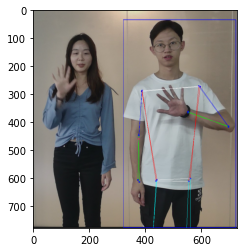

In [13]:
test(img=img1, pose_structure=pose_structure)

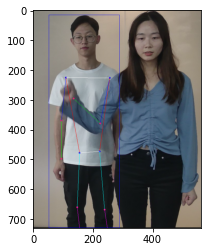

In [14]:
test(img=img2, pose_structure=pose_structure)